# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Beishi He
*   Student Number: 1005039548

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? - 284807 **[0.1]**

* What features in the dataset are present aside from the 28 main features?  - Time & Amount **[0.1]**
* Which column contains the targets? Last column: - Class [0.1]**
* To what do the target values correspond? - In the target column Class: 0 corresponds Valid, 1 corresponds to Fraud **[0.1]**

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=b9bb50d206760f20027819293ab31cf09d93d2dec22b43d2d800d52527dbe17f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [ ]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [ ]:
df.shape

(284807, 31)

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0



* What is the percentage of entries in the dataset for each class? **[0.1]**
  - 0.9982725143693799 % of transactions are valid(Class of 0)
  - 0.001727485630620034 % of transactions are fraud(Class of 1)
* Is this data considered balanced or unbalanced? Why is this the case? **[0.1]**
  - Unbalanced, because the percentage of valid transaction closes to 1,which is extremely high and the percentage of fraud transaction is very low around 0 
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? **[0.2]**
  - Imbalance will lead some biased, make it not objective.
  - In KNN algorithm, the assumption is the point near each other tends to belong the same class, there is bias. When data is unbalanced, the result tends to belong to the class that contains many same data, which always results wrong when the test data does not belong to that class.


In [ ]:
valid = (df['Class'] == 0).sum(axis = 0)
fraud = (df['Class'] == 1).sum(axis = 0)
total = len(df['Class'])
print(valid/total, '% of transactions are valid' )
print(fraud/total, '% of transactions are fraud' )

0.9982725143693799 % of transactions are valid
0.001727485630620034 % of transactions are fraud


Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [ ]:
### Split the data  ###
from sklearn.model_selection import train_test_split
X_train, X_left, y_train, y_left = train_test_split(df[df.columns[0:30]], df['Class'], train_size = 0.7, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_left, y_left, test_size = 0.5, random_state = 0)

#verify shape of data
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(199364, 30) (199364,)
(42721, 30) (42721,)
(42722, 30) (42722,)


Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

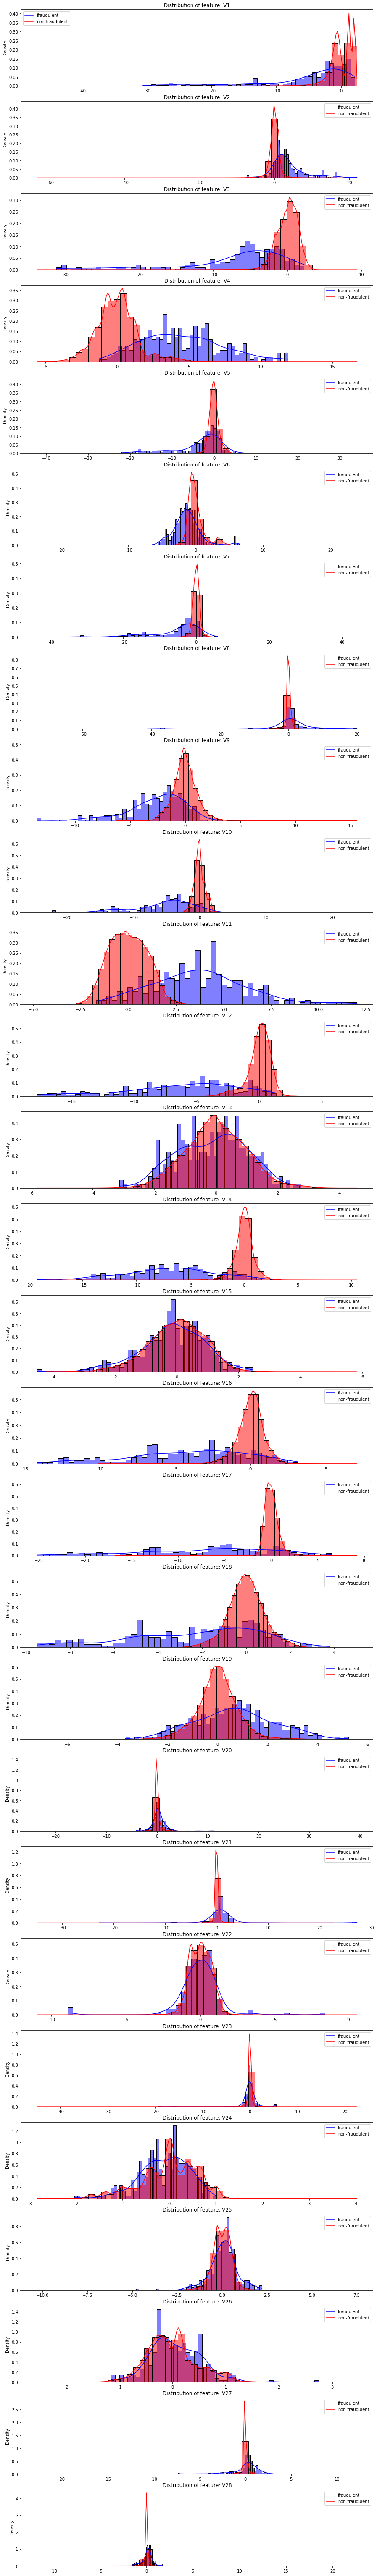

In [ ]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

The variables of non-fraudulent transactions are more dispersed than the fraudulent transactions. The fraud transaction has a large spread of data (large variance) where the Gaussian distribution is broad among all the features. The valid transaction has narrow Gaussian distribution, always centred at 0.

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





# a

In [ ]:
# 1
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V1_t = X_train[df.columns[1]].to_frame()
gm.fit(V1_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# 2
from sklearn.metrics import roc_auc_score
p_gm_t = gm.score_samples(V1_t)
print ("AUC on full training set is" , roc_auc_score(y_train, 1-p_gm_t))

V1_v = X_val[df.columns[1]].to_frame()
p_gm_v = gm.score_samples(V1_v)
print ("AUC on validation set is" , roc_auc_score(y_val, 1-p_gm_v))

AUC on full training set is 0.7051015812269326
AUC on validation set is 0.6948108661923188


In [ ]:
# 3
# Training set
AUC_t = []
for i in range(1, 29):
  gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
  feature_t = X_train[df.columns[i]].to_frame()
  gm.fit(feature_t)
  p_gm_t = gm.score_samples(feature_t)
  AUC = roc_auc_score(y_train, 1-p_gm_t)
  AUC_t.append(AUC)

feature_names = df.columns[1:29]
AUC_table = pd.DataFrame(data = feature_names, columns = ['feature_names'])
AUC_table['AUC_train'] = AUC_t

In [ ]:
# Validation set
AUC_v = []
for i in range(1, 29):
  gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
  feature_t = X_train[df.columns[i]].to_frame()
  gm.fit(feature_t)
  feature_v = X_val[df.columns[i]].to_frame()
  p_gm_v = gm.score_samples(feature_v)
  AUC = roc_auc_score(y_val, 1-p_gm_v)
  AUC_v.append(AUC)

AUC_table['AUC_validation'] = AUC_v
AUC_table

,feature_names,AUC_train,AUC_validation
0,V1,0.705102,0.694811
1,V2,0.837499,0.837800
2,V3,0.876537,0.838364
3,V4,0.892103,0.888283
4,V5,0.771825,0.786857
5,V6,0.734380,0.673559
6,V7,0.862967,0.867423
7,V8,0.773238,0.774130
8,V9,0.802874,0.776739
9,V10,0.913600,0.905959


In [ ]:
# 4
AUC_table.sort_values(by = ['AUC_validation'], ascending=False)
# The best features are V14, V10, V4, which have three highest AUC.

,feature_names,AUC_train,AUC_validation
13,V14,0.952459,0.938073
9,V10,0.913600,0.905959
3,V4,0.892103,0.888283
15,V16,0.902137,0.882852
10,V11,0.897175,0.882058
16,V17,0.934852,0.881858
6,V7,0.862967,0.867423
2,V3,0.876537,0.838364
11,V12,0.920180,0.837909
1,V2,0.837499,0.837800


In [ ]:
# 5
from sklearn.metrics import f1_score
# V14
V14_gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V14_t = X_train[df.columns[14]].to_frame()
V14_gm.fit(V14_t)
V14_v = X_val[df.columns[14]].to_frame()
V14_p_gm_v = V14_gm.score_samples(V14_v)
sorted_V14_p_gm_v = sorted(V14_p_gm_v)
f1_score_list = []
for i in range(0, 500): 
   mn_gm = sorted_V14_p_gm_v[i] 
   f1_sco = f1_score(y_val, V14_p_gm_v < mn_gm) 
   f1_score_list.append(f1_sco)

max_score_V14 = max(f1_score_list)
max_index = f1_score_list.index(max_score_V14)
threshold = sorted_V14_p_gm_v[max_index] 
print('The maximum F1 Score of V14 is', max_score_V14)
print('The corresponding optimal threhold of V14 is', threshold)

The maximum F1 Score of V14 is 0.5901639344262295
The corresponding optimal threhold of V14 is -19.312113472653234


In [ ]:
# V10
V10_gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V10_t = X_train[df.columns[10]].to_frame()
V10_gm.fit(V10_t)
V10_v = X_val[df.columns[10]].to_frame()
V10_p_gm_v = V10_gm.score_samples(V10_v)
sorted_V10_p_gm_v = sorted(V10_p_gm_v)
f1_score_list = []
for i in range(0, 500): 
   mn_gm = sorted_V10_p_gm_v[i] 
   f1_sco = f1_score(y_val, V10_p_gm_v < mn_gm) 
   f1_score_list.append(f1_sco) 
 
max_score_V10 = max(f1_score_list)
max_index = f1_score_list.index(max_score_V10)
threshold = sorted_V10_p_gm_v[max_index] 
print('The maximum F1 Score of V10 is', max_score_V10)
print('The corresponding optimal threhold of V10 is', threshold)

The maximum F1 Score of V10 is 0.2558139534883721
The corresponding optimal threhold of V10 is -57.92586903051879


In [ ]:
# V4
V4_gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V4_t = X_train[df.columns[4]].to_frame()
V4_gm.fit(V4_t)
V4_v = X_val[df.columns[4]].to_frame()
V4_p_gm_v = V4_gm.score_samples(V4_v)
sorted_V4_p_gm_v = sorted(V4_p_gm_v)
f1_score_list = []
for i in range(0, 500): # 3) for 6
   mn_gm = sorted_V4_p_gm_v[i] 
   f1_sco = f1_score(y_val, V4_p_gm_v < mn_gm) 
   f1_score_list.append(f1_sco)

max_score_V4 = max(f1_score_list)
max_index = f1_score_list.index(max_score_V4)
threshold = sorted_V4_p_gm_v[max_index] 
print('The maximum F1 Score of V4 is', max_score_V4)
print('The corresponding optimal threhold of V4 is', threshold)

The maximum F1 Score of V4 is 0.3619047619047619
The corresponding optimal threhold of V4 is -11.027680789942133


6. For the code line 1) mentioned above, V10_v has a shape of m * 1, where m is a integer, n_features = 1 and k, n_components = 1, fit() has a linear complexity with O(m), we ignore the running time here. 
For code 2), the sorted() built in function has O(mlogm) running time where m is the real number. For code 3), the for loop has O(mp) running time where p = 500. Thus, the complexity of the method should be O(mlogm + mp).

b

In [ ]:
# AUC and F1 score
# V14
V14_gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V14_nonfraud = X_train[y_train == 0][df.columns[14]].to_frame()
V14_gm_nonfraud.fit(V14_nonfraud)

V14_t = X_train[df.columns[14]].to_frame()
V14_p_gm_t_nonfraud = V14_gm_nonfraud.score_samples(V14_t)
V14_AUC_nonfraud_t = roc_auc_score(y_train, 1-V14_p_gm_t_nonfraud)

V14_v = X_val[df.columns[14]].to_frame()
V14_p_gm_v_nonfraud = V14_gm_nonfraud.score_samples(V14_v)
V14_AUC_nonfraud_v = roc_auc_score(y_val, 1-V14_p_gm_v_nonfraud)

sorted_V14_p_gm_t_nonfraud = sorted(V14_p_gm_t_nonfraud) 
f1_score_list_t = []
for i in range(0, 500): 
   mn_gm = sorted_V14_p_gm_t_nonfraud[i] 
   f1_sco = f1_score(y_train, V14_p_gm_t_nonfraud < mn_gm) 
   f1_score_list_t.append(f1_sco) 
V14_max_score_t = max(f1_score_list_t)

sorted_V14_p_gm_v_nonfraud = sorted(V14_p_gm_v_nonfraud) 
f1_score_list_v = []
for i in range(0, 500): 
   mn_gm = sorted_V14_p_gm_v_nonfraud[i] 
   f1_sco = f1_score(y_val, V14_p_gm_v_nonfraud < mn_gm) 
   f1_score_list_v.append(f1_sco) 
V14_max_score_v = max(f1_score_list_v)
print(V14_max_score_t)
print(V14_max_score_v)

0.6151515151515151
0.5901639344262295


In [ ]:
# V10
V10_gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V10_nonfraud = X_train[y_train == 0][df.columns[10]].to_frame()
V10_gm_nonfraud.fit(V10_nonfraud)

V10_t = X_train[df.columns[10]].to_frame()
V10_p_gm_t_nonfraud = V10_gm_nonfraud.score_samples(V10_t)
V10_AUC_nonfraud_t = roc_auc_score(y_train, 1-V10_p_gm_t_nonfraud)

V10_v = X_val[df.columns[10]].to_frame()
V10_p_gm_v_nonfraud = V10_gm_nonfraud.score_samples(V10_v)
V10_AUC_nonfraud_v = roc_auc_score(y_val, 1-V10_p_gm_v_nonfraud)

sorted_V10_p_gm_t_nonfraud = sorted(V10_p_gm_t_nonfraud) 
f1_score_list_t = []
for i in range(0, 500): 
   mn_gm = sorted_V10_p_gm_t_nonfraud[i] 
   f1_sco = f1_score(y_train, V10_p_gm_t_nonfraud < mn_gm) 
   f1_score_list_t.append(f1_sco) 
V10_max_score_t = max(f1_score_list_t)

sorted_V10_p_gm_v_nonfraud = sorted(V10_p_gm_v_nonfraud) 
f1_score_list_v = []
for i in range(0, 500): 
   mn_gm = sorted_V10_p_gm_v_nonfraud[i] 
   f1_sco = f1_score(y_val, V10_p_gm_v_nonfraud < mn_gm) 
   f1_score_list_v.append(f1_sco) 
V10_max_score_v = max(f1_score_list_v)

In [ ]:
# V4
V4_gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V4_nonfraud = X_train[y_train == 0][df.columns[4]].to_frame()
V4_gm_nonfraud.fit(V4_nonfraud)

V4_t = X_train[df.columns[4]].to_frame()
V4_p_gm_t_nonfraud = V4_gm_nonfraud.score_samples(V4_t)
V4_AUC_nonfraud_t = roc_auc_score(y_train, 1-V4_p_gm_t_nonfraud)

V4_v = X_val[df.columns[4]].to_frame()
V4_p_gm_v_nonfraud = V4_gm_nonfraud.score_samples(V4_v)
V4_AUC_nonfraud_v = roc_auc_score(y_val, 1-V4_p_gm_v_nonfraud)

sorted_V4_p_gm_t_nonfraud = sorted(V4_p_gm_t_nonfraud) 
f1_score_list_t = []
for i in range(0, 500): 
   mn_gm = sorted_V4_p_gm_t_nonfraud[i] 
   f1_sco = f1_score(y_train, V4_p_gm_t_nonfraud < mn_gm) 
   f1_score_list_t.append(f1_sco) 
V4_max_score_t = max(f1_score_list_t)

sorted_V4_p_gm_v_nonfraud = sorted(V4_p_gm_v_nonfraud) 
f1_score_list_v = []
for i in range(0, 500): 
   mn_gm = sorted_V4_p_gm_v_nonfraud[i] 
   f1_sco = f1_score(y_val, V4_p_gm_v_nonfraud < mn_gm) 
   f1_score_list_v.append(f1_sco) 
V4_max_score_v = max(f1_score_list_v)

In [ ]:
# 2
print("AUC of V14 on non-fraudulent transactions trainning set is" , V14_AUC_nonfraud_t)
print("AUC of V10 on non-fraudulent transactions training set is" , V10_AUC_nonfraud_t)
print("AUC of V4 on non-fraudulent transactions training set is" , V4_AUC_nonfraud_t)

print("AUC of V14 on non-fraudulent transactions validation set is" , V14_AUC_nonfraud_v)
print("AUC of V10 on non-fraudulent transactions validation set is" , V10_AUC_nonfraud_v)
print("AUC of V4 on non-fraudulent transactions validation set is" , V4_AUC_nonfraud_v)

print("The F1 score of V14 on non-fraudulent transactions training set is", V14_max_score_t)
print("The F1 score of V10 on non-fraudulent transactions training set is", V10_max_score_t)
print("The F1 score of V4 on non-fraudulent transactions training set is", V4_max_score_t)

print("The F1 score of V14 on non-fraudulent transactions validation set is", V14_max_score_v)
print("The F1 score of V10 on non-fraudulent transactions validation set is", V10_max_score_v)
print("The F1 score of V4 on non-fraudulent transactions validation set is", V4_max_score_v)

AUC of V14 on non-fraudulent transactions trainning set is 0.9525990781886603
AUC of V10 on non-fraudulent transactions training set is 0.9135581476417189
AUC of V4 on non-fraudulent transactions training set is 0.8926122340223726
AUC of V14 on non-fraudulent transactions validation set is 0.9380723335075922
AUC of V10 on non-fraudulent transactions validation set is 0.9058995359396576
AUC of V4 on non-fraudulent transactions validation set is 0.8888025759513026
The F1 score of V14 on non-fraudulent transactions training set is 0.6151515151515151
The F1 score of V10 on non-fraudulent transactions training set is 0.23045267489711932
The F1 score of V4 on non-fraudulent transactions training set is 0.3624338624338624
The F1 score of V14 on non-fraudulent transactions validation set is 0.5901639344262295
The F1 score of V10 on non-fraudulent transactions validation set is 0.25882352941176473
The F1 score of V4 on non-fraudulent transactions validation set is 0.3619047619047619


In [ ]:
# 3
data = [['V14', V14_AUC_nonfraud_t, V14_AUC_nonfraud_v, AUC_table.iloc[13]["AUC_train"], AUC_table.iloc[13]["AUC_validation"], V14_max_score_t, V14_max_score_v, max_score_V14],
        ['V10', V10_AUC_nonfraud_t, V10_AUC_nonfraud_v, AUC_table.iloc[9]["AUC_train"], AUC_table.iloc[9]["AUC_validation"], V10_max_score_t, V10_max_score_v, max_score_V10],
        ['V4', V4_AUC_nonfraud_t, V4_AUC_nonfraud_v, AUC_table.iloc[3]["AUC_train"], AUC_table.iloc[3]["AUC_validation"], V4_max_score_t, V4_max_score_v, max_score_V4]]
columns = ['feature_names', 'AUC of non-fraudulent in training', 'AUC of non-fraudulent in validation', 
           'AUC of all class in training', 'AUC of all class in validation',
           'F1 score of non-fraudulent in training', 'F1 score of non-fraudulent in validation', 
           'F1 score of all class in validation']
compare_table = pd.DataFrame(data = data, columns = columns)
compare_table

,feature_names,AUC of non-fraudulent in training,AUC of non-fraudulent in validation,AUC of all class in training,AUC of all class in validation,F1 score of non-fraudulent in training,F1 score of non-fraudulent in validation,F1 score of all class in validation
0,V14,0.952599,0.938072,0.952459,0.938073,0.615152,0.590164,0.590164
1,V10,0.913558,0.905900,0.913600,0.905959,0.230453,0.258824,0.255814
2,V4,0.892612,0.888803,0.892103,0.888283,0.362434,0.361905,0.361905


4. By comparing the results from 2a and 2b, the results are almost the same. The reason is that the data is unbalanced where the fraudulent transactions have very low amounts compared with the non-fraudulent transactions; after dropping off the fraudulent transactions, the result would not change a lot.

## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





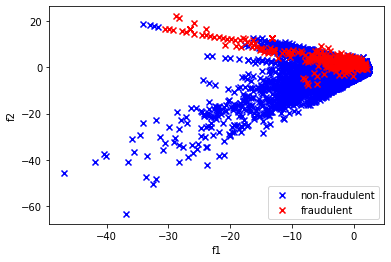

In [ ]:
# 1-3
import matplotlib.pyplot as plt
plt.scatter(X_train[y_train == 0][df.columns[1]], 
            X_train[y_train == 0][df.columns[2]], 
            label = 'non-fraudulent', 
            marker='x', color = 'b')
plt.scatter(X_train[y_train == 1][df.columns[1]], 
            X_train[y_train == 1][df.columns[2]], 
            label = 'fraudulent', 
            marker='x', color = 'r')
plt.legend()
plt.xlabel("f1")
plt.ylabel("f2")
plt.show()

4. We need to fit 2 Gaussian components, because we cluster most of valid transaction data around f1=0 and f2=0 and some non-frauduent transaction points around f1=-20 and f2=-20

In [ ]:
# 5
gm_V1V2 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
V1V2_t = X_train[[df.columns[1], df.columns[2]]]
gm_V1V2.fit(V1V2_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# 6
V1V2_p_gm_t = gm_V1V2.score_samples(V1V2_t)
print ("AUC on trainning set is" , roc_auc_score(y_train, 1-V1V2_p_gm_t))
V1V2_v = X_val[[df.columns[1], df.columns[2]]]
V1V2_p_gm_v = gm_V1V2.score_samples(V1V2_v)
print ("AUC on validation set is" , roc_auc_score(y_val, 1-V1V2_p_gm_v))

AUC on trainning set is 0.8684057475831999
AUC on validation set is 0.8608928210263914


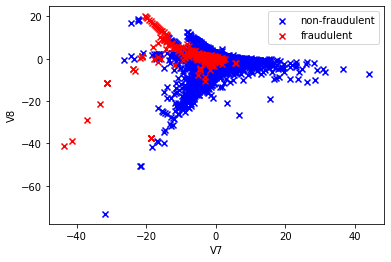

In [ ]:
# 7
# Pick three new pairs: V7 and V8, V17 and V18, V27 and V28
# V7 and V8
# 2-3
plt.scatter(X_train[y_train == 0][df.columns[7]], 
            X_train[y_train == 0][df.columns[8]], 
            label = 'non-fraudulent', 
            marker='x', color = 'b')
plt.scatter(X_train[y_train == 1][df.columns[7]], 
            X_train[y_train == 1][df.columns[8]], 
            label = 'fraudulent', 
            marker='x', color = 'r')
plt.legend()
plt.xlabel("V7")
plt.ylabel("V8")
plt.show()

4. We need to fit 3 Gaussian components, because we cluster most of non-frauduent transaction points around V7=0 and V8=0, some valid transaction points around (V7,V8)=(-10,-20) and (10,10).

In [ ]:
# 5
gm_V7V8 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
V7V8_t = X_train[[df.columns[7], df.columns[8]]]
gm_V7V8.fit(V7V8_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# 6
V7V8_p_gm_t = gm_V7V8.score_samples(V7V8_t)
print ("AUC on trainning set is" , roc_auc_score(y_train, 1-V7V8_p_gm_t))
V7V8_v = X_val[[df.columns[7], df.columns[8]]]
V7V8_p_gm_v = gm_V7V8.score_samples(V7V8_v)
print ("AUC on validation set is" , roc_auc_score(y_val, 1-V7V8_p_gm_v))

AUC on trainning set is 0.8459824569950389
AUC on validation set is 0.8391437103412464


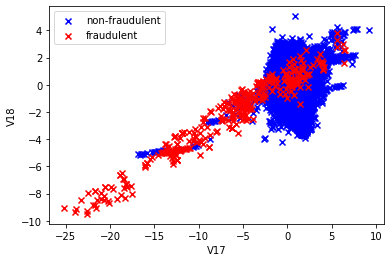

In [ ]:
# V17 and V18
# 2-3
plt.scatter(X_train[y_train == 0][df.columns[17]], 
            X_train[y_train == 0][df.columns[18]], 
            label = 'non-fraudulent', 
            marker='x', color = 'b')
plt.scatter(X_train[y_train == 1][df.columns[17]], 
            X_train[y_train == 1][df.columns[18]], 
            label = 'fraudulent', 
            marker='x', color = 'r')
plt.legend()
plt.xlabel("V17")
plt.ylabel("V18")
plt.show()

4. We need to fit 2 Gaussian components, because we cluster most of non-frauduent transaction points around V17=0 and V18=2, and some points at (V17, V18) = (3, 3)

In [ ]:
# 5
gm_V17V18 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
V17V18_t = X_train[[df.columns[17], df.columns[18]]]
gm_V17V18.fit(V17V18_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# 6
V17V18_p_gm_t = gm_V17V18.score_samples(V17V18_t)
print ("AUC on trainning set is" , roc_auc_score(y_train, 1-V17V18_p_gm_t))
V17V18_v = X_val[[df.columns[17], df.columns[18]]]
V17V18_p_gm_v = gm_V17V18.score_samples(V17V18_v)
print ("AUC on validation set is" , roc_auc_score(y_val, 1-V17V18_p_gm_v))

AUC on trainning set is 0.936154912308642
AUC on validation set is 0.878994743542101


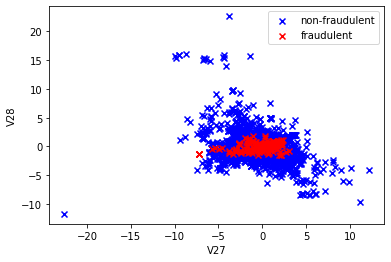

In [ ]:
# V27 and V28
# 2-3
plt.scatter(X_train[y_train == 0][df.columns[27]], 
            X_train[y_train == 0][df.columns[28]], 
            label = 'non-fraudulent', 
            marker='x', color = 'b')
plt.scatter(X_train[y_train == 1][df.columns[27]], 
            X_train[y_train == 1][df.columns[28]], 
            label = 'fraudulent', 
            marker='x', color = 'r')
plt.legend()
plt.xlabel("V27")
plt.ylabel("V28")
plt.show()

4. We need to fit 1 Gaussian components, because we cluster most of data around V27=0 and V28=0..

In [ ]:
# 5
gm_V27V28 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V27V28_t = X_train[[df.columns[27], df.columns[28]]]
gm_V27V28.fit(V27V28_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# 6
V27V28_p_gm_t = gm_V27V28.score_samples(V27V28_t)
print ("AUC on trainning set is" , roc_auc_score(y_train, 1-V27V28_p_gm_t))
V27V28_v = X_val[[df.columns[27], df.columns[28]]]
V27V28_p_gm_v = gm_V27V28.score_samples(V27V28_v)
print ("AUC on validation set is" , roc_auc_score(y_val, 1-V27V28_p_gm_v))

AUC on trainning set is 0.8527106180452801
AUC on validation set is 0.825003901578057


In [ ]:
# 8
# V7 and V8
sorted_V7V8_p_gm_v = sorted(V7V8_p_gm_v)
V7V8_f1_score_list = []
for i in range(0, 500): 
   mn_gm = sorted_V7V8_p_gm_v[i] 
   f1_sco = f1_score(y_val, V7V8_p_gm_v < mn_gm) 
   V7V8_f1_score_list.append(f1_sco)

max_score_V7V8 = max(V7V8_f1_score_list)
max_index_V7V8 = V7V8_f1_score_list.index(max_score_V7V8)
threshold_V7V8 = sorted_V7V8_p_gm_v[max_index_V7V8] 
print('The maximum F1 Score of V7 and V8 is', max_score_V7V8)
print('The corresponding optimal threhold of V7 and V8 is', threshold_V7V8)

The maximum F1 Score of V7 and V8 is 0.16568047337278105
The corresponding optimal threhold of V7 and V8 is -11.588685550912645


In [ ]:
# V17 and V18
sorted_V17V18_p_gm_v = sorted(V17V18_p_gm_v)
V17V18_f1_score_list = []
for i in range(0, 500): 
   mn_gm = sorted_V17V18_p_gm_v[i] 
   f1_sco = f1_score(y_val, V17V18_p_gm_v < mn_gm) 
   V17V18_f1_score_list.append(f1_sco)

max_score_V17V18 = max(V17V18_f1_score_list)
max_index_V17V18 = V17V18_f1_score_list.index(max_score_V17V18)
threshold_V17V18 = sorted_V17V18_p_gm_v[max_index_V17V18] 
print('The maximum F1 Score of V17 and V18 is', max_score_V17V18)
print('The corresponding optimal threhold of V17 and V18 is', threshold_V17V18)

The maximum F1 Score of V17 and V18 is 0.5
The corresponding optimal threhold of V17 and V18 is -12.953846061086988


In [ ]:
# V27 and V28
sorted_V27V28_p_gm_v = sorted(V27V28_p_gm_v)
V27V28_f1_score_list = []
for i in range(0, 500): 
   mn_gm = sorted_V27V28_p_gm_v[i] 
   f1_sco = f1_score(y_val, V27V28_p_gm_v < mn_gm) 
   V27V28_f1_score_list.append(f1_sco)

max_score_V27V28 = max(V27V28_f1_score_list)
max_index_V27V28 = V27V28_f1_score_list.index(max_score_V27V28)
threshold_V27V28 = sorted_V27V28_p_gm_v[max_index_V27V28] 
print('The maximum F1 Score of V27 and V28 is', max_score_V27V28)
print('The corresponding optimal threhold of V27 and V28 is', threshold_V27V28)

The maximum F1 Score of V27 and V28 is 0.031055900621118012
The corresponding optimal threhold of V27 and V28 is -22.169336440875405


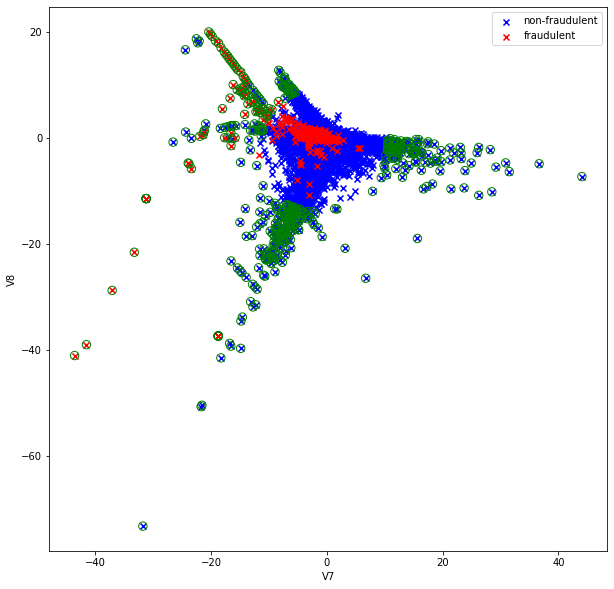

In [ ]:
# 9
# V7 and V8
plt.figure(figsize=(10,10))
c = V7V8_p_gm_t
plt.scatter(X_train[y_train == 0][df.columns[7]], 
            X_train[y_train == 0][df.columns[8]], 
            label = 'non-fraudulent', 
            marker='x', color = 'b')
plt.scatter(X_train[y_train == 1][df.columns[7]], 
            X_train[y_train == 1][df.columns[8]], 
            label = 'fraudulent', 
            marker='x', color = 'r')
outliers = c<threshold_V7V8
plt.scatter(X_train[[df.columns[7]]][outliers], 
            X_train[[df.columns[8]]][outliers],
            marker="o", facecolor= "none", edgecolor="g", s=70)
plt.legend()
plt.xlabel("V7")
plt.ylabel("V8")
plt.show()

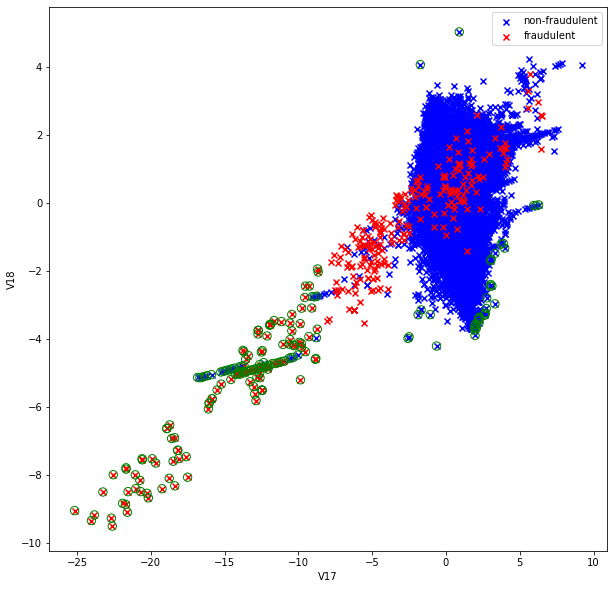

In [ ]:
# V17 and V18
plt.figure(figsize=(10,10))
c = V17V18_p_gm_t
plt.scatter(X_train[y_train == 0][df.columns[17]], 
            X_train[y_train == 0][df.columns[18]], 
            label = 'non-fraudulent', 
            marker='x', color = 'b')
plt.scatter(X_train[y_train == 1][df.columns[17]], 
            X_train[y_train == 1][df.columns[18]], 
            label = 'fraudulent', 
            marker='x', color = 'r')
outliers = c<threshold_V17V18
plt.scatter(X_train[[df.columns[17]]][outliers], 
            X_train[[df.columns[18]]][outliers],
            marker="o",facecolor= "none",edgecolor="g",s=70)
plt.legend()
plt.xlabel("V17")
plt.ylabel("V18")
plt.show()

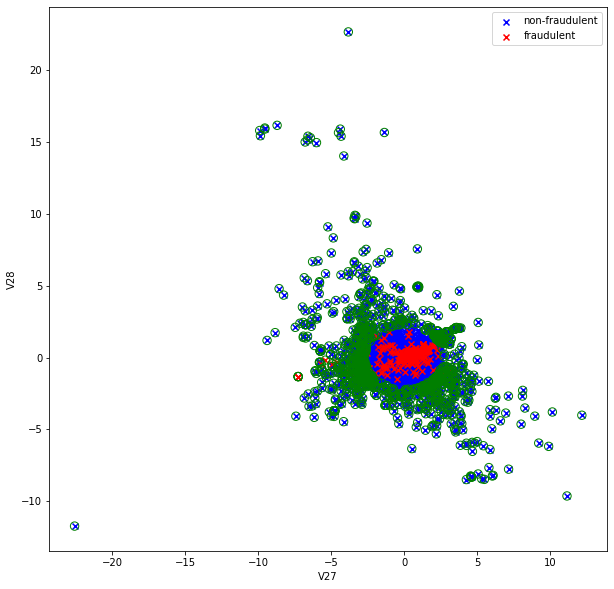

In [ ]:
# V27 and V28
plt.figure(figsize=(10,10))
c = V27V28_p_gm_t
plt.scatter(X_train[y_train == 0][df.columns[27]], 
            X_train[y_train == 0][df.columns[28]], 
            label = 'non-fraudulent', 
            marker='x', color = 'b')
plt.scatter(X_train[y_train == 1][df.columns[27]], 
            X_train[y_train == 1][df.columns[28]], 
            label = 'fraudulent', 
            marker='x', color = 'r')
outliers = c<threshold_V27V28
plt.scatter(X_train[[df.columns[27]]][outliers], 
            X_train[[df.columns[28]]][outliers],
            marker="o", facecolor= "none", edgecolor="g", s=70)
plt.legend()
plt.xlabel("V27")
plt.ylabel("V28")
plt.show()

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

In [ ]:
# 1 for V1
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_V1_t = X_train[y_train == 0][df.columns[1]].to_frame()
gm_nonfraud.fit(G1_V1_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# 2 for V1
gm_fraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_V1_t = X_train[y_train == 1][df.columns[1]].to_frame()
gm_fraud.fit(G2_V1_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# 3
S1 = gm_nonfraud.fit(G1_V1_t).score_samples(X_val[df.columns[1]].to_frame())
S2 = gm_fraud.fit(G2_V1_t).score_samples(X_val[df.columns[1]].to_frame())
print('score samples for G1 is', S1)
print('score samples for G2 is', S2)

score samples for G1 is [-1.68953662 -2.1231417  -1.59074919 ... -1.755135   -1.6535887
 -1.66827917]
score samples for G2 is [-3.23135559 -3.3695449  -3.10436342 ... -3.25902918 -3.0666335
 -3.06097064]


In [ ]:
# 4
c_list = []
f1_score_list = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1 < c * S2)
  f1_score_list.append(f1_sco)
  c_list.append(c)
max_f1_score_V1 = max(f1_score_list)
max_index = f1_score_list.index(max_f1_score_V1)
c = c_list[max_index]
print('The optimal c that maximizes validation ser F1 Score is', c)

The optimal c that maximizes validation ser F1 Score is 5.0


In [ ]:
# 5
# Training set
# An empty list whihc will contain a list of maximum F1 Score for 28 features after loop.
train_f1_score_list = []
# An empty list which will contain a list of corresponding optimal c value.
train_c_list = []
for i in range(1, 29):
  G1_Vi_t = X_train[y_train == 0][df.columns[i]].to_frame()
  gm_nonfraud.fit(G1_Vi_t)
  G2_Vi_t = X_train[y_train == 1][df.columns[i]].to_frame()
  gm_fraud.fit(G2_Vi_t)  
  S1 = gm_nonfraud.fit(G1_Vi_t).score_samples(X_train[df.columns[i]].to_frame())
  S2 = gm_fraud.fit(G2_Vi_t).score_samples(X_train[df.columns[i]].to_frame())
  c_list = []
  f1_score_list = []
  for c in np.arange(0, 10, 0.1):
    f1_sco = f1_score(y_train, S1 < c * S2)
    f1_score_list.append(f1_sco)
    c_list.append(c)
  max_f1_score = max(f1_score_list)
  train_f1_score_list.append(max_f1_score)
  max_index = f1_score_list.index(max_f1_score)
  c = c_list[max_index]
  train_c_list.append(c)

In [ ]:
train_best_f1_score = max(train_f1_score_list)
train_index = train_f1_score_list.index(train_best_f1_score)
train_c = train_c_list[train_index]
train_feature = df.columns[train_index]
print('For training set, the best F1 Score is', train_best_f1_score, ',the feature is', train_feature, ', and the corresponding optimal c value is', train_c)

For training set, the best F1 Score is 0.6866666666666666 ,the feature is V11 , and the corresponding optimal c value is 5.0


In [ ]:
# Validation set
# An empty list whihc will contain a list of maximum F1 Score for 28 features after loop.
val_f1_score_list = []
# An empty list which will contain a list of corresponding optimal c value.
val_c_list = []
for i in range(1, 29):
  G1_Vi_t = X_train[y_train == 0][df.columns[i]].to_frame()
  gm_nonfraud.fit(G1_Vi_t)
  G2_Vi_t = X_train[y_train == 1][df.columns[i]].to_frame()
  gm_fraud.fit(G2_Vi_t)  
  S1 = gm_nonfraud.fit(G1_Vi_t).score_samples(X_val[df.columns[i]].to_frame())
  S2 = gm_fraud.fit(G2_Vi_t).score_samples(X_val[df.columns[i]].to_frame())
  c_list = []
  f1_score_list = []
  for c in np.arange(0, 10, 0.1):
    f1_sco = f1_score(y_val, S1 < c * S2)
    f1_score_list.append(f1_sco)
    c_list.append(c)
  max_f1_score = max(f1_score_list)
  val_f1_score_list.append(max_f1_score)
  max_index = f1_score_list.index(max_f1_score)
  c = c_list[max_index]
  val_c_list.append(c)

In [ ]:
val_best_f1_score = max(val_f1_score_list)
val_index = val_f1_score_list.index(val_best_f1_score)
val_c = val_c_list[val_index]
val_feature = df.columns[val_index]
print('For validation set, the best F1 Score is', val_best_f1_score, ',the feature is', val_feature, ', and the corresponding optimal c value is', val_c)

For validation set, the best F1 Score is 0.6545454545454547 ,the feature is V16 , and the corresponding optimal c value is 7.2


## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**


**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

Model1: One Gaussian distribution with 1 component and 3 features(V2, V4, V22)

In [ ]:
# Model1:
gm_m1 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
m1_V_t = X_train[[df.columns[2], df.columns[4], df.columns[22]]]
gm_m1.fit(m1_V_t)
m1_p_gm_t = gm_m1.score_samples(m1_V_t)
auc_m1_t = roc_auc_score(y_train, 1-m1_p_gm_t)
print ("AUC of model 1 on trainning set is" , auc_m1_t)

m1_V_v = X_val[[df.columns[2], df.columns[4], df.columns[22]]]
m1_p_gm_v = gm_m1.score_samples(m1_V_v)
auc_m1_v = roc_auc_score(y_val, 1-m1_p_gm_v)
print ("AUC of model 1 on validation set is" , auc_m1_v)

sorted_m1_p_gm_t = sorted(m1_p_gm_t)
f1_score_list_m1_t = []
for i in range(0, 500): 
   mn_gm = sorted_m1_p_gm_t[i] 
   f1_sco = f1_score(y_train, m1_p_gm_t < mn_gm) 
   f1_score_list_m1_t.append(f1_sco)
max_score_m1_t = max(f1_score_list_m1_t)
print('The maximum F1 Score of model1 for training set is', max_score_m1_t)

sorted_m1_p_gm_v = sorted(m1_p_gm_v)
f1_score_list_m1_v = []
for i in range(0, 500): 
   mn_gm = sorted_m1_p_gm_v[i] 
   f1_sco = f1_score(y_val, m1_p_gm_v < mn_gm) 
   f1_score_list_m1_v.append(f1_sco)

max_score_m1_v = max(f1_score_list_m1_v)
print('The maximum F1 Score of model1 for validation set is', max_score_m1_v)

AUC of model 1 on trainning set is 0.8944243397924793
AUC of model 1 on validation set is 0.8660911926511765
The maximum F1 Score of model1 for training set is 0.14388489208633093
The maximum F1 Score of model1 for validation set is 0.12286689419795221


Model2: One Gaussian distribution with 1 component and 8 features(V2, V3, V4, V5, V22, V23, V24, V25)

In [ ]:
# Model2:
gm_m2 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
m2_V_t = X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
gm_m2.fit(m2_V_t)
m2_p_gm_t = gm_m2.score_samples(m2_V_t)
auc_m2_t = roc_auc_score(y_val, 1-m2_p_gm_v)
print ("AUC of model 2 on trainning set is" , auc_m2_t)

m2_V_v = X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
m2_p_gm_v = gm_m2.score_samples(m2_V_v)
auc_m2_v = roc_auc_score(y_val, 1-m2_p_gm_v)
print ("AUC of model 2 on validation set is" , auc_m2_v)

sorted_m2_p_gm_t = sorted(m2_p_gm_t)
f1_score_list_m2_t = []
for i in range(0, 500): 
   mn_gm = sorted_m2_p_gm_t[i] 
   f1_sco = f1_score(y_train, m2_p_gm_t < mn_gm) 
   f1_score_list_m2_t.append(f1_sco)
max_score_m2_t = max(f1_score_list_m2_t)
print('The maximum F1 Score of model2 for training set is', max_score_m2_t)

sorted_m2_p_gm_v = sorted(m2_p_gm_v)
f1_score_list_m2_v = []
for i in range(0, 500): 
   mn_gm = sorted_m2_p_gm_v[i] 
   f1_sco = f1_score(y_val, m2_p_gm_v < mn_gm) 
   f1_score_list_m2_v.append(f1_sco)

max_score_m2_v = max(f1_score_list_m2_v)
print('The maximum F1 Score of model2 for validation set is', max_score_m2_v)

AUC of model 2 on trainning set is 0.8697299828050631
AUC of model 2 on validation set is 0.8697299828050631
The maximum F1 Score of model2 for training set is 0.16476552598225602
The maximum F1 Score of model2 for validation set is 0.14285714285714285


Model3: One Gaussian distribution with 4 component and 8 features(V2, V3, V4, V5, V22, V23, V24, V25)

In [ ]:
# Model3:
gm_m3 = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
m3_V_t = X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
gm_m3.fit(m3_V_t)
m3_p_gm_t = gm_m3.score_samples(m3_V_t)
auc_m3_t = roc_auc_score(y_val, 1-m3_p_gm_v)
print ("AUC of model 3 on trainning set is" , auc_m3_t)

m3_V_v = X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
m3_p_gm_v = gm_m3.score_samples(m3_V_v)
auc_m3_v = roc_auc_score(y_val, 1-m3_p_gm_v)
print ("AUC of model 3 on validation set is" , auc_m3_v)

sorted_m3_p_gm_t = sorted(m3_p_gm_t)
f1_score_list_m3_t = []
for i in range(0, 500): 
   mn_gm = sorted_m3_p_gm_t[i] 
   f1_sco = f1_score(y_train, m3_p_gm_t < mn_gm) 
   f1_score_list_m3_t.append(f1_sco)
max_score_m3_t = max(f1_score_list_m3_t)
print('The maximum F1 Score of model3 for training set is', max_score_m3_t)

sorted_m3_p_gm_v = sorted(m3_p_gm_v)
f1_score_list_m3_v = []
for i in range(0, 500): 
   mn_gm = sorted_m3_p_gm_v[i] 
   f1_sco = f1_score(y_val, m3_p_gm_v < mn_gm) 
   f1_score_list_m3_v.append(f1_sco)

max_score_m3_v = max(f1_score_list_m3_v)
print('The maximum F1 Score of model3 for validation set is', max_score_m3_v)

AUC of model 3 on trainning set is 0.8879620745617811
AUC of model 3 on validation set is 0.8903939998978241
The maximum F1 Score of model3 for training set is 0.19166666666666665
The maximum F1 Score of model3 for validation set is 0.16352201257861634


Model4: Two-Gaussian distribution with 1 component and 3 features(V2, V4, V22)

In [ ]:
# Model4
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m4_t = X_train[y_train == 0][[df.columns[2], df.columns[4], df.columns[22]]]
G1_m4 = gm_nonfraud.fit(G1_m4_t)

gm_fraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m4_t = X_train[y_train == 1][[df.columns[2], df.columns[4], df.columns[22]]]
G2_m4 = gm_fraud.fit(G2_m4_t)


S1_t = G1_m4.score_samples(X_train[[df.columns[2], df.columns[4], df.columns[22]]])
S2_t = G2_m4.score_samples(X_train[[df.columns[2], df.columns[4], df.columns[22]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m4_t = max(f1_score_list_t)
print('The maximum F1 Score of model4 for training set is', max_f1_score_m4_t)

S1_v = G1_m4.score_samples(X_val[[df.columns[2], df.columns[4], df.columns[22]]])
S2_v = G2_m4.score_samples(X_val[[df.columns[2], df.columns[4], df.columns[22]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m4_v = max(f1_score_list_v)
print('The maximum F1 Score of model4 for validation set is', max_f1_score_m4_v)

The maximum F1 Score of model4 for training set is 0.3927855711422846
The maximum F1 Score of model4 for validation set is 0.38


Model5: Two-Gaussian distribution with 1 component and 8 features(V2, V3, V4, V5, V22, V23, V24, V25)

In [ ]:
# Model5
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m5_t = X_train[y_train == 0][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G1_m5 = gm_nonfraud.fit(G1_m5_t)

gm_fraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m5_t = X_train[y_train == 1][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G2_m5 = gm_fraud.fit(G2_m5_t)


S1_t = G1_m5.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_t = G2_m5.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m5_t = max(f1_score_list_t)
print('The maximum F1 Score of model5 for training set is', max_f1_score_m5_t)

S1_v = G1_m5.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_v = G2_m5.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m5_v = max(f1_score_list_v)
print('The maximum F1 Score of model5 for validation set is', max_f1_score_m5_v)

The maximum F1 Score of model5 for training set is 0.3245614035087719
The maximum F1 Score of model5 for validation set is 0.3023255813953488


Mode6: Two-Gaussian distribution with 4 component and 8 features(V2, V3, V4, V5, V22, V23, V24, V25)

In [ ]:
# Model6
gm_nonfraud = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
G1_m6_t = X_train[y_train == 0][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G1_m6 = gm_nonfraud.fit(G1_m6_t)

gm_fraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m6_t = X_train[y_train == 1][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G2_m6 = gm_fraud.fit(G2_m6_t)


S1_t = G1_m6.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_t = G2_m6.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m6_t = max(f1_score_list_t)
print('The maximum F1 Score of model6 for training set is', max_f1_score_m6_t)

S1_v = G1_m6.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_v = G2_m6.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m6_v = max(f1_score_list_v)
print('The maximum F1 Score of model6 for validation set is', max_f1_score_m6_v)

The maximum F1 Score of model6 for training set is 0.5248713550600344
The maximum F1 Score of model6 for validation set is 0.4807692307692308


Model7: Two-Gaussian distribution with 4 component and all features

In [ ]:
# Model7
gm_nonfraud = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
G1_m7_t = X_train[y_train == 0]
G1_m7 = gm_nonfraud.fit(G1_m7_t)

gm_fraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m7_t = X_train[y_train == 1]
G2_m7 = gm_fraud.fit(G2_m7_t)


S1_t = G1_m7.score_samples(X_train)
S2_t = G2_m7.score_samples(X_train)

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m7_t = max(f1_score_list_t)
print('The maximum F1 Score of model7 for training set is', max_f1_score_m7_t)

S1_v = G1_m7.score_samples(X_val)
S2_v = G2_m7.score_samples(X_val)

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m7_v = max(f1_score_list_v)
print('The maximum F1 Score of model7 for validation set is', max_f1_score_m7_v)

The maximum F1 Score of model7 for training set is 0.7585185185185185
The maximum F1 Score of model7 for validation set is 0.7419354838709676


Model8: Two-Gaussian distribution with  3 features(V2, V4, V22), 1 component for valid transaction, 3 components for fraudulent transaction


In [ ]:
# Model8
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m8_t = X_train[y_train == 0][[df.columns[2], df.columns[4], df.columns[22]]]
G1_m8 = gm_nonfraud.fit(G1_m8_t)

gm_fraud = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G2_m8_t = X_train[y_train == 1][[df.columns[2], df.columns[4], df.columns[22]]]
G2_m8 = gm_fraud.fit(G2_m8_t)

S1_t = G1_m8.score_samples(X_train[[df.columns[2], df.columns[4], df.columns[22]]])
S2_t = G2_m8.score_samples(X_train[[df.columns[2], df.columns[4], df.columns[22]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m8_t = max(f1_score_list_t)
print('The maximum F1 Score of model8 for training set is', max_f1_score_m8_t)

S1_v = G1_m8.score_samples(X_val[[df.columns[2], df.columns[4], df.columns[22]]])
S2_v = G2_m8.score_samples(X_val[[df.columns[2], df.columns[4], df.columns[22]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m8_v = max(f1_score_list_v)
print('The maximum F1 Score of model8 for validation set is', max_f1_score_m8_v)

The maximum F1 Score of model8 for training set is 0.5326278659611994
The maximum F1 Score of model8 for validation set is 0.43809523809523804


Model9: Two-Gaussian distribution with 8 features(V2, V3, V4, V5, V22, V23, V24, V25)), 1 component for valid transaction, 3 components for fraudulent transaction

In [ ]:
# Model9
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m9_t = X_train[y_train == 0][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G1_m9 = gm_nonfraud.fit(G1_m9_t)

gm_fraud = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G2_m9_t = X_train[y_train == 1][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G2_m9 = gm_fraud.fit(G2_m9_t)


S1_t = G1_m9.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_t = G2_m9.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m9_t = max(f1_score_list_t)
print('The maximum F1 Score of model9 for training set is', max_f1_score_m9_t)

S1_v = G1_m9.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_v = G2_m9.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m9_v = max(f1_score_list_v)
print('The maximum F1 Score of model9 for validation set is', max_f1_score_m9_v)

The maximum F1 Score of model9 for training set is 0.44921316165951364
The maximum F1 Score of model9 for validation set is 0.373134328358209


Model10: Two-Gaussian distribution with all features, 1 component for valid transaction, 3 components for fraudulent transaction

In [ ]:
# Model10
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m10_t = X_train[y_train == 0]
G1_m10 = gm_nonfraud.fit(G1_m10_t)

gm_fraud = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G2_m10_t = X_train[y_train == 1]
G2_m10 = gm_fraud.fit(G2_m10_t)


S1_t = G1_m10.score_samples(X_train)
S2_t = G2_m10.score_samples(X_train)

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m10_t = max(f1_score_list_t)
print('The maximum F1 Score of model10 for training set is', max_f1_score_m10_t)

S1_v = G1_m10.score_samples(X_val)
S2_v = G2_m10.score_samples(X_val)

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m10_v = max(f1_score_list_v)
print('The maximum F1 Score of model10 for validation set is', max_f1_score_m10_v)

The maximum F1 Score of model10 for training set is 0.8148148148148149
The maximum F1 Score of model10 for validation set is 0.7377049180327869


Model11: Two-Gaussian distribution with 8 features(V2, V3, V4, V5, V22, V23, V24, V25)), 1 component for valid transaction, 4 components for fraudulent transaction

In [ ]:
# Model11
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m11_t = X_train[y_train == 0][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G1_m11 = gm_nonfraud.fit(G1_m11_t)

gm_fraud = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
G2_m11_t = X_train[y_train == 1][[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                 df.columns[22], df.columns[23],df.columns[24], df.columns[25]]]
G2_m11 = gm_fraud.fit(G2_m11_t)


S1_t = G1_m11.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_t = G2_m11.score_samples(X_train[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                    df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m11_t = max(f1_score_list_t)
print('The maximum F1 Score of model11 for training set is', max_f1_score_m11_t)

S1_v = G1_m11.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])
S2_v = G2_m11.score_samples(X_val[[df.columns[2], df.columns[3], df.columns[4], df.columns[5], 
                                  df.columns[22], df.columns[23],df.columns[24], df.columns[25]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m11_v = max(f1_score_list_v)
print('The maximum F1 Score of model11 for validation set is', max_f1_score_m11_v)

The maximum F1 Score of model11 for training set is 0.46795827123695977
The maximum F1 Score of model11 for validation set is 0.4032258064516129


Model12: Two-Gaussian distribution with 4 features(V11, V12, V13, V14)), 1 component for valid transaction, 4 components for fraudulent transaction

In [ ]:
# Model12
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m12_t = X_train[y_train == 0][[df.columns[11], df.columns[12], df.columns[13], df.columns[14]]]
G1_m12 = gm_nonfraud.fit(G1_m12_t)

gm_fraud = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
G2_m12_t = X_train[y_train == 1][[df.columns[11], df.columns[12], df.columns[13], df.columns[14]]]
G2_m12 = gm_fraud.fit(G2_m12_t)


S1_t = G1_m12.score_samples(X_train[[df.columns[11], df.columns[12], df.columns[13], df.columns[14]]])
S2_t = G2_m12.score_samples(X_train[[df.columns[11], df.columns[12], df.columns[13], df.columns[14]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m12_t = max(f1_score_list_t)
print('The maximum F1 Score of model12 for training set is', max_f1_score_m12_t)

S1_v = G1_m12.score_samples(X_val[[df.columns[11], df.columns[12], df.columns[13], df.columns[14]]])
S2_v = G2_m12.score_samples(X_val[[df.columns[11], df.columns[12], df.columns[13], df.columns[14]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m12_v = max(f1_score_list_v)
print('The maximum F1 Score of model12 for validation set is', max_f1_score_m12_v)

The maximum F1 Score of model12 for training set is 0.751552795031056
The maximum F1 Score of model12 for validation set is 0.7258064516129032


Model13: Two-Gaussian distribution with 5 features(V11, V12, V13, V14, V17)), 1 component for valid transaction, 4 components for fraudulent transaction

In [ ]:
# Model13
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m13_t = X_train[y_train == 0][[df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]]
G1_m13 = gm_nonfraud.fit(G1_m13_t)

gm_fraud = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
G2_m13_t = X_train[y_train == 1][[df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]]
G2_m13 = gm_fraud.fit(G2_m13_t)


S1_t = G1_m13.score_samples(X_train[[df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])
S2_t = G2_m13.score_samples(X_train[[df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m13_t = max(f1_score_list_t)
print('The maximum F1 Score of model13 for training set is', max_f1_score_m13_t)

S1_v = G1_m13.score_samples(X_val[[df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])
S2_v = G2_m13.score_samples(X_val[[df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m13_v = max(f1_score_list_v)
print('The maximum F1 Score of model13 for validation set is', max_f1_score_m13_v)

The maximum F1 Score of model13 for training set is 0.7987897125567323
The maximum F1 Score of model13 for validation set is 0.7716535433070867


Model14: Two-Gaussian distribution with 6 features(V10, V11, V12, V13, V14, V17)), 1 component for valid transaction, 3 components for fraudulent transaction

In [ ]:
# Model14
gm_nonfraud = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m14_t = X_train[y_train == 0][[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]]
G1_m14 = gm_nonfraud.fit(G1_m14_t)

gm_fraud = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
G2_m14_t = X_train[y_train == 1][[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]]
G2_m14 = gm_fraud.fit(G2_m14_t)


S1_t = G1_m14.score_samples(X_train[[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])
S2_t = G2_m14.score_samples(X_train[[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])

f1_score_list_t = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_train, S1_t < c * S2_t)
  f1_score_list_t.append(f1_sco)
max_f1_score_m14_t = max(f1_score_list_t)
print('The maximum F1 Score of model14 for training set is', max_f1_score_m14_t)

S1_v = G1_m14.score_samples(X_val[[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])
S2_v = G2_m14.score_samples(X_val[[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])

f1_score_list_v = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_val, S1_v < c * S2_v)
  f1_score_list_v.append(f1_sco)
max_f1_score_m14_v = max(f1_score_list_v)
print('The maximum F1 Score of model14 for validation set is', max_f1_score_m14_v)

The maximum F1 Score of model14 for training set is 0.8210526315789473
The maximum F1 Score of model14 for validation set is 0.8


In [93]:
data = [['Model1', auc_m1_t, auc_m1_v, max_score_m1_t, max_score_m1_v], 
        ['Model2', auc_m2_t, auc_m2_v, max_score_m2_t, max_score_m2_v],
        ['Model3', auc_m3_t, auc_m3_v, max_score_m3_t, max_score_m3_v],
        ['Model4', 'NA', 'NA', max_f1_score_m4_t, max_f1_score_m4_v],
        ['Model5', 'NA', 'NA', max_f1_score_m5_t, max_f1_score_m5_v],
        ['Model6', 'NA', 'NA', max_f1_score_m6_t, max_f1_score_m6_v],
        ['Model7', 'NA', 'NA', max_f1_score_m7_t, max_f1_score_m7_v],
        ['Model8', 'NA', 'NA', max_f1_score_m8_t, max_f1_score_m8_v],
        ['Model9', 'NA', 'NA', max_f1_score_m9_t, max_f1_score_m9_v],
        ['Model10', 'NA', 'NA', max_f1_score_m10_t, max_f1_score_m10_v],
        ['Model11', 'NA', 'NA', max_f1_score_m11_t, max_f1_score_m11_v],
        ['Model12', 'NA', 'NA', max_f1_score_m12_t, max_f1_score_m12_v],
        ['Model13', 'NA', 'NA', max_f1_score_m13_t, max_f1_score_m13_v],
        ['Model14', 'NA', 'NA', max_f1_score_m14_t, max_f1_score_m14_v]]
columns = ['Model_names', 'AUC in training', 'AUC in validation', 
           'F1 score in training', 'F1 score in validation']
summary_table = pd.DataFrame(data = data, columns = columns)
summary_table

,Model_names,AUC in training,AUC in validation,F1 score in training,F1 score in validation
0,Model1,0.894424,0.866091,0.143885,0.122867
1,Model2,0.86973,0.86973,0.164766,0.142857
2,Model3,0.887962,0.890394,0.191667,0.163522
3,Model4,NA,NA,0.392786,0.380000
4,Model5,NA,NA,0.324561,0.302326
5,Model6,NA,NA,0.524871,0.480769
6,Model7,NA,NA,0.758519,0.741935
7,Model8,NA,NA,0.532628,0.438095
8,Model9,NA,NA,0.449213,0.373134
9,Model10,NA,NA,0.814815,0.737705


In conclusion, two-gaussian model performs better than one gaussian model after compared with validation F1 Score. Model14 has the highest F1 Score = 0.8 in the validation set. The model is a two-gaussian model, a single component for the valid transaction, and 3 components for the fraudulent transaction. There are 6 best features; they are V10, V11, V12, V13, V14, V17. The valid transaction always has similar features, but the fraudulent ones have multiple feature data. Thus, it makes sense the two-gaussian model which has a single component for the valid transaction and multiple components for the fraudulent ones performs the best.

## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


In [ ]:
# Model14 worked better. The model is a two-gaussian model, a single
# component for the valid transaction, and 3 components for the 
# fraudulent transaction. 6 best features: V10, V11, V12, V13, V14, V17.
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
S1_test = G1_m14.score_samples(X_test[[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])
S2_test = G2_m14.score_samples(X_test[[df.columns[10], df.columns[11], df.columns[12], df.columns[13], df.columns[14], df.columns[17]]])

c_list_test = []
f1_score_list_test = []
for c in np.arange(0, 10, 0.1):
  f1_sco = f1_score(y_test, S1_test < c * S2_test)
  f1_score_list_test.append(f1_sco)
  c_list_test.append(c)
max_f1_score_m14_test = max(f1_score_list_test)
print('F1 Score is', max_f1_score_m14_test)
max_index_test = f1_score_list_test.index(max_f1_score_m14_test)
c = c_list_test[max_index_test]
precision = precision_score(y_test, S1_test < c * S2_test) 
recall = recall_score(y_test, S1_test < c * S2_test)
print('Precision is', precision)
print('Recall is', recall)

F1 Score is 0.8322981366459627
Precision is 0.8271604938271605
Recall is 0.8375


## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 




Chi-square distribution is a continuous distribution which is a special case of the gamma distribution can also use to model the data. The chi-square distribution is a continuous distribution which is a special case of the gamma distribution. It is widely used in statistics, especially in the goodness of fit testing. 

A chi-square statistics is a measure of the difference between the observed and expected frequencies of the outcomes of a set of events. This distribution works very well in analyzing such differences in categorical variables. It can be used to test whether two variables are related or independent from one another. 

To find a suitable distribution to model the data, we can use probability plots such as quantile-quantile plots and QQ plots, and determine whether the data follow a particular distribution. If the data follows the straight line on the graph, the distribution fits the data.

Reference:

Chi-square distribution. Chi-Square Distribution - an overview | ScienceDirect Topics. (n.d.). Retrieved October 22, 2021, from https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/chi-square-distribution. 

Hayes, A. (2021, September 21). Chi-Square (Χ2) statistic definition.    Investopedia. Retrieved October 22, 2021, from https://www.investopedia.com/terms/c/chi-square-statistic.asp.

